# Determine whether staff member at a salon has any effect on the average price for an appointment, controlling for the effect of month

*In this video, you will continue to use the salon data. Let's go ahead and load in libraries first, however. You will need rcompanion for testing the assumption of normality, car for testing the assumption of homogeneity of variance, and then effects and multcomp are both new, brought in to help deal with the covariate portion of this.  The effects library helps you create means that are adjusted by your covariate, and multcomp does post hocs that are adjusted by the covariate. You may also want the IDPmisc library, so that if you need to deal with missing data, you can easily.*  

## Load Libraries

In [11]:
library("rcompanion")
library("car")
library("effects")
library("multcomp")
library("dplyr")
library("IDPmisc")
library("psych")


Attaching package: 'psych'

The following object is masked from 'package:car':

    logit



## Read in Data

*Then it's time to read in the data.*

In [1]:
salon <- read.csv('../data/client_cancellations.csv')

In [2]:
head(salon)

cancel.date,cancel.date.month,code,service.code,service.desc,staff,booking.date,booking.date.month,canceled.by,days.in.adv,avg.price
3/10/2018,March,KOOM01,SHCW,Women's hair cut,JJ,4/3/2018,April,JJ,24,88.44
3/27/2018,March,WIL*01,SHCW,Women's hair cut,JJ,3/29/2018,March,JJ,2,88.44
4/3/2018,April,BUDG02,SHCM,Men's hair cut,SINEAD,4/21/2018,April,BECKY,18,41.41
4/3/2018,April,HILJ01,CFC,Color full color,KELLY,4/3/2018,April,JJ,0,63.13
4/3/2018,April,STEM01,SHCW,Women's hair cut,BECKY,4/21/2018,April,JJ,18,67.84
4/3/2018,April,STRH01,CHLFH,Highlights full,KELLY,4/4/2018,April,JJ,1,120.00


## Exploring Covariates

*This time with the salon data, you will control for the effect of month.  When picking covariates, you can either use theory and your gut instincts to try some out, or you can use the information you've learned from a data exploration phase to determine whether it looks like there are some effects you want to control for. In this case, looking at the salon data, it seemed like perhaps the seasons may have an affect on salon cancellations.  So, to very simply test this theory, you can do a group by, and see if the your DV does in fact differ based on a potential covariate.* 

*This is very easily done with some of the dplyr tools and using the summarize function.  You can group by the month, and then summarize it based on the average price.*

In [5]:
salonMeans <- salon %>% group_by(cancel.date.month) %>% summarize(Mean = mean(avg.price))

*And then, of course, you need to call it.*

In [6]:
salonMeans

cancel.date.month,Mean
April,66.93696
July,NA
June,NA
March,88.44000
May,67.57014


*Aha! Remember that dplyr functions do not automatically handle missing data, so you will need to remove it yourself using the NaRV.omit function from IDPmisc*

In [8]:
salon2 <- NaRV.omit(salon)

*And now you just need to change your code so that it runs on your new dataset, salon2, instead of the original data.*

In [9]:
salonMeans <- salon2 %>% group_by(cancel.date.month) %>% summarize(Mean = mean(avg.price))

In [10]:
salonMeans

cancel.date.month,Mean
April,66.93696
July,68.85682
June,70.72655
March,88.44000
May,67.57014


*And now you have variables for everything.  Looks like the gut hunch was right - there are some months that have a higher price to them for cancellations.  Looks like March has the most expensive cancellations, while the others are relatively the same. So you can use a dummy coded covariate of March or Not March to help control for the seasonal effects that might play into how staff members influence the average price of a cancelled appointment.*

*Luckily, there is a way to automatically dummy code things, so you don't have to do the work yourself.  That's why you brought in the psych library. You'll use the function dummy.code out of it and run it on the month varaible.*

In [12]:
salon3 <- dummy.code(salon2$cancel.date.month)

*And take a peek.  Now you have everything dummy coded as zeroes and ones, so that you have March as a 1 if the month was March, and 0 if the month was anything else but March.*

In [13]:
head(salon3)

April,July,June,March,May
0,0,0,1,0
0,0,0,1,0
1,0,0,0,0
1,0,0,0,0
1,0,0,0,0
1,0,0,0,0


*Of course, your next step is to place this info back onto your original dataset.*

In [14]:
salon4 <- data.frame(salon2, salon3)

In [15]:
head(salon4)

cancel.date,cancel.date.month,code,service.code,service.desc,staff,booking.date,booking.date.month,canceled.by,days.in.adv,avg.price,April,July,June,March,May
3/10/2018,March,KOOM01,SHCW,Women's hair cut,JJ,4/3/2018,April,JJ,24,88.44,0,0,0,1,0
3/27/2018,March,WIL*01,SHCW,Women's hair cut,JJ,3/29/2018,March,JJ,2,88.44,0,0,0,1,0
4/3/2018,April,BUDG02,SHCM,Men's hair cut,SINEAD,4/21/2018,April,BECKY,18,41.41,1,0,0,0,0
4/3/2018,April,HILJ01,CFC,Color full color,KELLY,4/3/2018,April,JJ,0,63.13,1,0,0,0,0
4/3/2018,April,STEM01,SHCW,Women's hair cut,BECKY,4/21/2018,April,JJ,18,67.84,1,0,0,0,0
4/3/2018,April,STRH01,CHLFH,Highlights full,KELLY,4/4/2018,April,JJ,1,120.00,1,0,0,0,0


*There. With that done, you now have the variable March set up as your covariate. It's not time to move onto data wrangling!*

## Data Wrangling

*The first thing you need to do for data wrangling is to ensure that your IV is a factor. You can find this out by using the str() function, which stands for structure.*

### Ensure the IV is a factor

In [67]:
str(salon4$staff)

 Factor w/ 6 levels "BECKY","JJ","JOANNE",..: 2 2 5 4 1 4 5 4 2 5 ...


*And luckily it is a factor, so no work needed there.  Your CV also needs to be a factor, so check that too...*

### Ensure the CV is a factor

In [68]:
str(salon4$March)

 Factor w/ 2 levels "0","1": 2 2 1 1 1 1 1 1 1 1 ...


*Well, that is listed as numeric right now, so you will turn it into a factor.  That can easily be done with the function as.factor().*

In [69]:
salon4$March <- as.factor(salon4$March)

*And then go ahead and just doulbe check to make sure that worked...*

In [70]:
str(salon4$March)

 Factor w/ 2 levels "0","1": 2 2 1 1 1 1 1 1 1 1 ...


*Tada! You have a factor. Jolly good. Now you are on to testing assumptions.*

## Test Assumptions

*Almost all of your assumptions for ANCOVAs are the same as ANOVAs - but there is one additional assumption, called the homogeneity of regression slopes, which you will test for. In addition, your sample size requirements go up, because you have included a CV.*

### Normality

*You still need to test the normality of your dependent variable, and if you had a continuous covariate, rather than a categorical one, you would need to test the normality of that as well. Take a look at the shape of this data and see if it needs any transformations.*

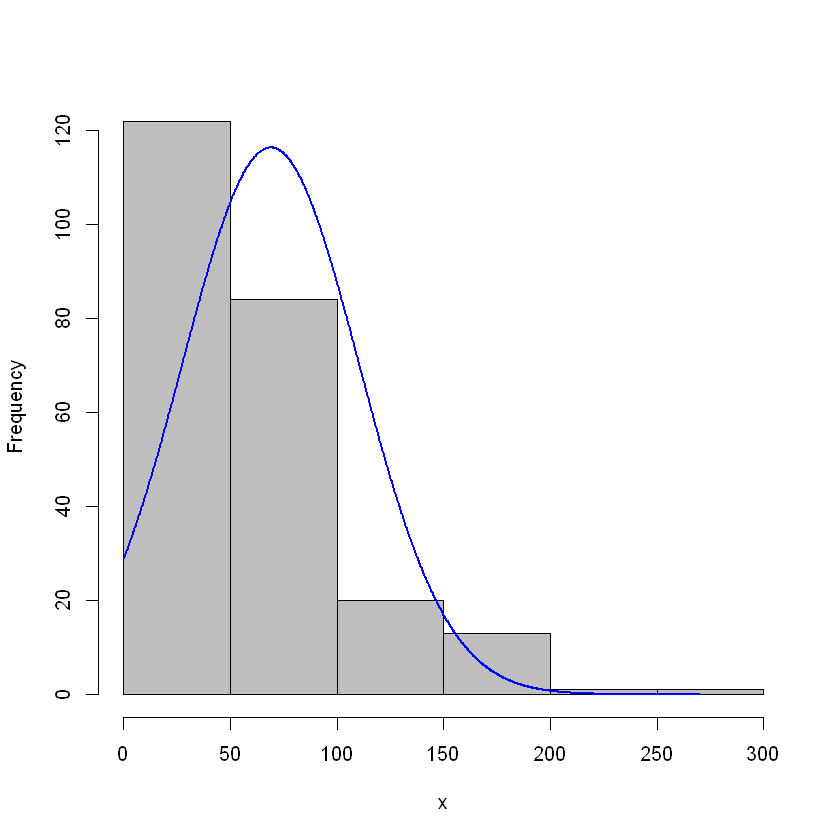

In [71]:
plotNormalHistogram(salon4$avg.price)

*Looks like it does, in fact, need a square root transformation, because it is positively skewed.*

In [72]:
salon4$avg.priceSQRT <- sqrt(salon4$avg.price)

*And check to make sure that did what you wanted it to.*

In [73]:
head(salon4)

cancel.date,cancel.date.month,code,service.code,service.desc,staff,booking.date,booking.date.month,canceled.by,days.in.adv,avg.price,April,July,June,March,May,avg.priceSQRT
3/10/2018,March,KOOM01,SHCW,Women's hair cut,JJ,4/3/2018,April,JJ,24,88.44,0,0,0,1,0,9.404254
3/27/2018,March,WIL*01,SHCW,Women's hair cut,JJ,3/29/2018,March,JJ,2,88.44,0,0,0,1,0,9.404254
4/3/2018,April,BUDG02,SHCM,Men's hair cut,SINEAD,4/21/2018,April,BECKY,18,41.41,1,0,0,0,0,6.435060
4/3/2018,April,HILJ01,CFC,Color full color,KELLY,4/3/2018,April,JJ,0,63.13,1,0,0,0,0,7.945439
4/3/2018,April,STEM01,SHCW,Women's hair cut,BECKY,4/21/2018,April,JJ,18,67.84,1,0,0,0,0,8.236504
4/3/2018,April,STRH01,CHLFH,Highlights full,KELLY,4/4/2018,April,JJ,1,120.00,1,0,0,0,0,10.954451


*Alright, that looks just fine. Now see if the shape of the data is more approximately normal.*

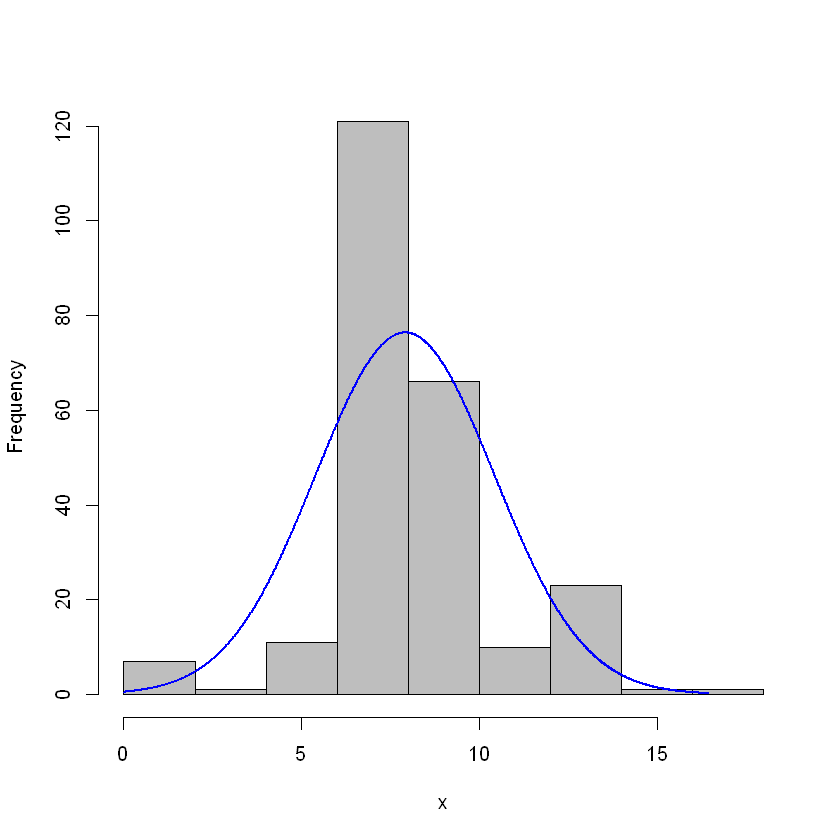

In [74]:
plotNormalHistogram(salon4$avg.priceSQRT)

*And now that looks beautiful! Definitely pretty much normal, so bravo.*

### Homogeneity of Variance

*Next you'll use the Levene's test to test for the assumption of homogeneity of variance.  Unfortunately, Levene's test does not allow for any covariates to be included, but you'll try for testing the model as best you are able without the covariates.*

*You'll use the function leveneTest from the car library, and place your DV first, followed by a tilde and your IV, then specify your data with the argument data=*

In [75]:
leveneTest(avg.priceSQRT~staff, data=salon4)

,Df,F value,Pr(>F)
group,5,6.131987,2.318731e-05
,235,NA,NA


*To pass the assumption of homogeneity of variance, you want Levene's test to be non-significant, meaning greater than .05.  Unfortunately, it is much less than .05, so you have violated the assumption of homogeneity of variance.  Luckily, however, there is a way to correct for this when you run the actual test, so it is not a big deal.*

### Homogeneity of Regression Slopes

*The next assumption you will test is teh new one, homogeneity of regression slopes.  The basic idea behind this is that you want to see if your CV and your DV are significantly related in any way.  You don't want them to be related, because if they are, what you were planning to use as a CV should most likely be an IV instead.  The way you test the homogeneity of regression slopes is to run another ANOVA, with the planned CV instead as the IV, and using your planned DV as the DV.*

In [76]:
HomogeneityRegr = lm(avg.priceSQRT~March, data=salon4)

In [77]:
anova(HomogeneityRegr)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
March,1,4.49048,4.490480,0.7076632,0.4010615
Residuals,239,1516.57570,6.345505,NA,NA


*Phew! Luckily the result of this is not significant, and so you have met the assumption of homogeneity of regression slopes. If this test had been significant, you can still run your analysis, but use the CV as an IV instead.*

### Sample Size

*The last assumption there is to test is sample size.  There must be 20 cases for every IV OR CV.  The Or CV part is the new part for covariates! Since you have one IV and one CV, you will need at least 40 rows of data. There are 243 rows here, so you are good to go!*

*You are now all prepped to run your ANCOVA.  You will actually run the ANCOVA in the next video! See you there!*

# END VIDEO ONE

*Alright! Now that you have tested all your assumptions, it is time to actually run the analsyis, interpret it, and draw conclusions.  These conclusions will be based on the presence of your covariate, since you are controlling for that information.*

*Now, from the last video, you know that you violated the assumption of homogeneity of variance, so you will want to run the ANCOVA to correct for that violation.  However, here you'll be shown both methods so you know what to do if you have NOT violated the assumption.  Let's start with the ANCOVA for when you have met the assumption of homogeneity of variance first.*

*You are going to use the function lm() from the car package, standing for linear model.  It is yet another way that you can generate ANOVAs! Once you have that open, you want your DV to go first, followed by a tilde and then the CV next.  Then you can add a plus sign and add in your IV, and cross it using the asterisk with your Covariate. This asterisk creates what is called the interaction term, and it looks at how your CV and your IV work in concert. And then of course you need to finish it up by specifying your data. Then you need to call your ANCOVA with the anova function, to make it look like an F test should, instead of a regression.*

## Run the analysis when you have met the assumption of homogeneity of variance

In [82]:
ANCOVA3 = lm(avg.priceSQRT~March + staff, data=salon4)
anova(ANCOVA3)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
March,1,4.49048,4.490480,0.8126766,3.682570e-01
staff,5,223.59841,44.719681,8.0932631,4.623991e-07
Residuals,234,1292.97729,5.525544,NA,NA


*An interesting thing about including the asterisk is that it will only show the effects if it meets the assumption of multicollinearity, which is NOT an assumption of ANOVA, but is an assumption of regression, which is the other test that uses the lm() function.  In this case, even though it wouuld be fine to include the interaction for an ANOVA, it would not be for regression, and thus you are missing a line that shows how the IV and CV interact.  However, you do get plenty of other fun results: there is a significant effect of the covariate, as well as a significant effect of the staff member. You'll explore those results further in a few minutes, but for right now, you will also learn how to do the ANCOVA when you have violated the assumption of homogeneity of variance.*

## Run the analysis when you have NOT met the assumption of homogeneity of variance

*If you have violated the assumption of homogeneity of variance, don't fear.  It's not a deal breaker.  Instead of running a linear model and using the little a ANOVA function, you can run the big A anova function.  Not confusing at all, is it? But seriously, pay attention to the capitalization because in this case, it does matter.*

*You'll put in the name of the model you created above, and then you'll specify the Type. Type has to do with how the ANCOVA is calculated via the sum of squares.  You don't need to get into all the details of that, but suffice it to say that typically, you are good to specify I and leave it at that.  II is for when you are looking for very specific effects, and II is not suitable if you have a factorial ANOVA.  If you don't specify anything at all, R will default to I, and that's a good rule of thumb too.*

*What is really important, though, is that you include the argument of white.adjust=TRUE. That is what corrects for a violation of homogeneity of variance, and so it is critical that you include it!*

In [83]:
Anova(ANCOVA3, Type="I", white.adjust=TRUE)

Coefficient covariances computed by hccm()


,Df,F,Pr(>F)
March,1,48.927192,2.765981e-11
staff,5,5.501485,8.264054e-05
Residuals,234,NA,NA


*If you haven't gotten your interaction to show for the previous ANCOVA, you most likely will get this error when you try to use the capital A anova function as well. That is ok - simply go back and change it so you don't have an interaction term and then run again, like this.*

## Post Hocs

*Right! You know that there is a significant effect of both the covariate and the independent variable, so it's time to figure out what levels of the independent variable and CV differ from each other! You will do this with the multcomp package, which was designed to handle the covariates and other interaction effects, using the glht() function. You will specify the model you're using, then use the standard code of linfct=mcp(), and then you will specify your independent variable.*

In [85]:
postHocs <- glht(ANCOVA3, linfct=mcp(staff = "Tukey"))
summary(postHocs)


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lm(formula = avg.priceSQRT ~ March + staff, data = salon4)

Linear Hypotheses:
                     Estimate Std. Error t value Pr(>|t|)    
JJ - BECKY == 0       1.02713    0.41750   2.460  0.12587    
JOANNE - BECKY == 0   2.80754    0.46192   6.078  < 0.001 ***
KELLY - BECKY == 0    0.92949    0.46493   1.999  0.32087    
SINEAD - BECKY == 0   0.27971    0.61758   0.453  0.99724    
TANYA - BECKY == 0   -0.16749    1.21325  -0.138  0.99999    
JOANNE - JJ == 0      1.78041    0.45443   3.918  0.00134 ** 
KELLY - JJ == 0      -0.09764    0.45749  -0.213  0.99993    
SINEAD - JJ == 0     -0.74741    0.61200  -1.221  0.80989    
TANYA - JJ == 0      -1.19462    1.21042  -0.987  0.91312    
KELLY - JOANNE == 0  -1.87805    0.49837  -3.768  0.00251 ** 
SINEAD - JOANNE == 0 -2.52782    0.64312  -3.931  0.00131 ** 
TANYA - JOANNE == 0  -2.97503    1.22645  -2.426  0.13640    
SINEAD -

*The information that results has been adjusted by the scores of the covariate, which is pretty nifty. You can see that off to the side of each comparison has ==0, which means that they are all being compared only when it wasn't March, to keep things nice and even. The significant ones are being marked with stars on the right hand side, so you can see that Joanne differs from Becky, JJ, Kelly, and Sinead. Very similar to the results that you received from a regular one way ANOVA, actually.* 

## Determine Means and Draw Conclusions

*And of course the last step is to see HOW Joanne differed from the other girls.  Did she have a higher or lower average price?  You can just the effect function from the effects package to look at the means adjusted by the covariate of the month of march. Just specify your IV in quotes, and then put that ubiquitous model afterwards.*

In [86]:
adjMeans <- effect("staff", ANCOVA3)
adjMeans


 staff effect
staff
   BECKY       JJ   JOANNE    KELLY   SINEAD    TANYA 
6.909061 7.936187 9.716597 7.838547 7.188775 6.741571 

*Now, this looks kind of funky, doesn't it? You get an idea of who did better (Joanne), but the units don't make sense.  That is not a product of adjusting for the covariate, but rather is because you were using the SQRT of average price.  The easy fix for this is to create a new model that has regular price, that you can run just to get the adjusted means (not for p values)*

In [87]:
ANCOVA4 = lm(avg.price~March + staff, data=salon4)
anova(ANCOVA4)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
March,1,769.0391,769.0391,0.5744855,4.492446e-01
staff,5,95453.3680,19090.6736,14.2610618,3.471090e-12
Residuals,234,313245.7927,1338.6572,NA,NA


In [88]:
adjMeans2 <- effect("staff", ANCOVA4)
adjMeans2


 staff effect
staff
    BECKY        JJ    JOANNE     KELLY    SINEAD     TANYA 
 51.25367  65.84454 108.23153  66.32681  52.92277  52.41158 

*Now, don't those look better? They have been adjusted for month, so they will not hook back into your actual original data means.  If you don't believe me, let's go ahead and examine the raw means:*

In [89]:
salonMeans2 <- salon4 %>% group_by(staff) %>% summarize(Mean = mean(avg.price))
salonMeans2

staff,Mean
BECKY,51.06459
JJ,66.32559
JOANNE,108.04244
KELLY,66.13773
SINEAD,52.73368
TANYA,52.22250


*In this case, there clearly wasn't much of an effect of the month of march on the sales, in the end, since the raw means here are very close to the adjusted means.  Nevertheless, they are not the same - for instance Joanne's raw mean is 108.04, while the adjusted mean is 108.23.  If there is a larger influence of the covariate, then you would also see a larger difference betweeen your raw and adjusted means.*

*Congratulations! You now know how to control for a variable in a model using ANCOVA - which is something infinitely useful that you can utilize again and again.*